In [23]:
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import LinkNeighborLoader, NeighborLoader
from torch_geometric.nn import GraphSAGE


In [64]:
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F

In [53]:
from torch_geometric.data import Data

In [148]:
# Example graph data
# edge_index = torch.tensor([[0, 1, 2, 0, 1, 3, 4], [1, 0, 0, 2, 3, 1, 2]], dtype=torch.long)
# x = torch.tensor([[1, 0], [0, 1], [1, 1], [0, 0], [1, 2]], dtype=torch.float)  # 4 nodes, 2 features each
edges = [[0,1], [1, 2], [1, 3], [2, 4], [2,5], [2,7], [3,6]]
edge_index = [[src for src, tgt in edges] +  [tgt for src, tgt in edges], [tgt for src, tgt in edges] +  [src for src, tgt in edges]]
edge_index = torch.tensor(edge_index, dtype=torch.long)
x = torch.tensor([[i, i+1] for i in range(8)])
data = Data(x=x, edge_index=edge_index)

# Model hyperparameters
input_dim = 2
hidden_dim = 16
output_dim = 8

In [149]:
data

Data(x=[8, 2], edge_index=[2, 14])

In [198]:
data.edge_index

tensor([[0, 1, 1, 2, 2, 2, 3, 1, 2, 3, 4, 5, 7, 6],
        [1, 2, 3, 4, 5, 7, 6, 0, 1, 1, 2, 2, 2, 3]])

### Graph Viz

In [211]:
import networkx as nx
import matplotlib.pyplot as plt

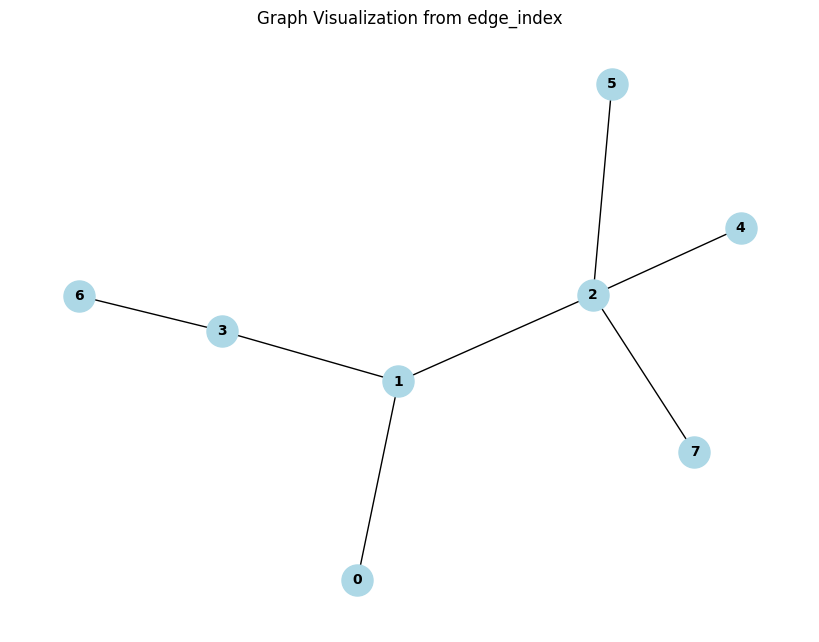

In [212]:
# Convert edge_index to networkx graph
def edge_index_to_networkx(edge_index):
    # Create a directed or undirected graph (undirected here)
    G = nx.Graph()
    
    # Add edges to the graph
    edges = edge_index.t().tolist()  # Convert to edge list
    G.add_edges_from(edges)
    
    return G

# Create networkx graph
G = edge_index_to_networkx(edge_index)

# Visualize the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
plt.title("Graph Visualization from edge_index")
plt.show()

### Demo Model

In [150]:
class TwoLayerGraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerGraphSAGE, self).__init__()
        # First GraphSAGE convolutional layer
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        # Second GraphSAGE convolutional layer
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        # First layer: GraphSAGE aggregation and non-linearity
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        print(x.shape)
        # Second layer: GraphSAGE aggregation (output embeddings)
        x = self.conv2(x, edge_index)
        print(x.shape)
        return x

### Neighbour Loader 

GraphSage Neighbourhood sampling

uniform sampling - randomly sample fixed number of neighbours for each node.
Neighbourhood sampling is performed for L layers of the GNN. For a 2 layered GNN, you sample the neighbours, of the target node at layer 1
and the neighbours of those neighbours at layer 2.


In [209]:
# Neighbor sampling loader
for i in range(1):
    train_loader = NeighborLoader(
        data,
        batch_size=2, # selects 2 seed nodes from the total set of nodes in the graph, These seed nodes are the "target nodes" for which the model will compute embeddings.
        shuffle=True,
        num_neighbors=[3, 1],  # Sample n[i] neighbors for i'th iteration
        input_nodes = [3] # The indices of nodes for which neighbors are sampled to create mini-batches.
    )
    for mini_batch in train_loader:
        # print(f"{mini_batch = }")
        # print(f"{mini_batch.input_id=}")
        # print(f"{mini_batch.x = }")
        # print(f"{mini_batch.edge_index = }")
        print(f"{mini_batch.n_id = }")

mini_batch.n_id = tensor([3, 1, 6, 2])


In [110]:
data.edge_index

tensor([[0, 1, 2, 0, 1, 3, 4],
        [1, 0, 0, 2, 3, 1, 2]])

* :obj:`batch_size` The number of seed nodes (first nodes in the batch)
* :obj:`n_id` The global node index for every sampled node
* :obj:`e_id` The global edge index for every sampled edge
* :obj:`input_id`: The global index of the :obj:`input_nodes`
* :obj:`num_sampled_nodes`: The number of sampled nodes in each hop
* :obj:`num_sampled_edges`: The number of sampled edges in each hop

In [83]:
mini_batch.input_id

tensor([2])

In [213]:
# Instantiate model and optimizer
model = TwoLayerGraphSAGE(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [215]:
# # Training loop
# model.train()
# for epoch in range(2):
#     for batch in train_loader:
#         optimizer.zero_grad()
        
#         # Forward pass
#         out = model(batch.x, batch.edge_index)
#         # print(out.shape)
#         # Example loss (MSE with dummy target embeddings)
#         target = torch.ones_like(out)
#         loss = F.mse_loss(out, target)
        
#         loss.backward()
#         optimizer.step()
        
#         print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

### Link Neighbour Loader

 link-based data loader derived as an extension of the node-based torch_geometric.loader.NeighborLoader. This loader allows for mini-batch training of GNNs on large-scale graphs where full-batch training is not feasible.

 More specifically, this loader first selects a sample of edges from the set of input edges edge_label_index (which may or not be edges in the original graph) and then constructs a subgraph from all the nodes present in this list by sampling num_neighbors neighbors in each iteration.



In [235]:
for _ in range(50):
    train_loader = LinkNeighborLoader(
        data,
        # Sample 1 neighbors for each node for 2 iterations
        num_neighbors=[1],
        # Use a batch size of 1 for sampling training nodes
        batch_size=1,
        edge_label_index=torch.tensor([[1], [0]]), # The edge indices for which neighbors are sampled to create mini-batches.
    )

    for mini_batch in train_loader:
            # print(f"{mini_batch = }")
            # print(f"{mini_batch.input_id=}")
            # print(f"{mini_batch.x = }")
            # print(f"{mini_batch.edge_index = }")
            print(f"{mini_batch.n_id = }")
            # print(f'{mini_batch.e_id = }')
            # print(f"{mini_batch.edge_label_index = }")


mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1, 2])
mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1, 2])
mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1, 2])
mini_batch.n_id = tensor([0, 1, 2])
mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1, 2])
mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1, 2])
mini_batch.n_id = tensor([0, 1, 2])
mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1, 2])
mini_batch.n_id = tensor([0, 1, 2])
mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1, 2])
mini_batch.n_id = tensor([0, 1, 2])
mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1, 2])
mini_batch.n_id = tensor([0, 1])
mini_batch.n_id = tensor([0, 1])
mini_ba